# Single Burst
This notebook evaluates the results of the single burst workload. 

You can generate results for different stages of the pipeline by changing the NOTEBOOK_PHASE parameter: 1, 2, and 3 are valid options.

In [169]:
NOTEBOOK_PHASE = 3 # you can change this to 1, 2, or 3 to see results from other stages

In [170]:
# settings for saving plots
saveplots = True
dpiResolution = 200

In [171]:
from pyspark.sql.functions import *
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
from matplotlib.ticker import AutoMinorLocator

In [172]:
# Python imports
import pandas as pd 
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import numpy as np
import pytz
import math

# SQL imports
from pyspark.sql.functions import isnan, when, count, col, lead, udf, lag, to_date, avg, desc, sum
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [173]:
# settings to get plots in the right style
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('axes',edgecolor='black')

In [174]:
# check if Spark is running
spark

In [175]:
# Structured Streaming does not have an implementation for the 4th stage
if NOTEBOOK_PHASE < 4:
    frameworks = ["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
else: 
    frameworks = ["FLINK", "KAFKASTREAMS", "SPARK"]
    
    
frameworksPrintable = {
    "SPARK": "Spark Streaming", 
    "STRUCTUREDSTREAMING":"Structured Streaming", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Streams"   
}
stages=["ingest", "parse", "join", "tumbling\nwindow", "sliding\nwindow"]

In [176]:
dataPath = dict()
for i in frameworks:
        dataPath[i] = "./data/" + i + "/single-burst/phase" + str(NOTEBOOK_PHASE) + "/*"

In [177]:
dataPath

{'FLINK': './data/FLINK/single-burst/phase3/*',
 'KAFKASTREAMS': './data/KAFKASTREAMS/single-burst/phase3/*',
 'SPARK': './data/SPARK/single-burst/phase3/*',
 'STRUCTUREDSTREAMING': './data/STRUCTUREDSTREAMING/single-burst/phase3/*'}

## General Methods

For printing the quantiles of a column:
provide a list of quantiles

In [179]:
def datetimeFromEpoch(epoch):
    return datetime.utcfromtimestamp(epoch//1000).replace(microsecond=epoch%1000*1000)

datetimeFromEpochUDF = functions.udf(datetimeFromEpoch, TimestampType())

In [182]:
def save_img_colored_and_grayscale(path_colored_img):
    if saveplots: 
        plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches=0)
        im = Image.open(path_colored_img + '.png').convert('L')
        im.save(path_colored_img + '_grayscale.png', dpi=(300, 300))

In [183]:
# Save the data in here
completeResults = dict()


for framework in frameworks:
        try:
            completeResults[framework] = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/results.csv/*")
        except:
            print("no data for " +  framework + " for stage " + str(phase))

In [184]:
# Save the frameworks present in the data in here
containerCheck = dict()
for framework in frameworks:
        requiredAmtContainers = 5 if framework == "KAFKASTREAMS" else 6
        containerCheckPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*")
        amtOfContainers = containerCheckPhase.select("containerName").distinct().count()
        if amtOfContainers != requiredAmtContainers:
            print("WARNING FOR " + framework + " volume: " + str(phase))
        else:
            print("all checks passed")

all checks passed
all checks passed
all checks passed
all checks passed


# Throughput

## Stage 0 throughput

In [185]:
throughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
        try:
            throughputDataForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/output-throughput-timeseries-second-buckets.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))
            minTime = throughputDataForPhase.toPandas()['startTime'][0]
            minTimeSec = minTime/60000.0
            throughputTimeseriesDataWithStartup[framework] = throughputDataForPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec)
        except:
            print("no data for " +  framework + " for stage " + str(phase))

In [186]:
inputThroughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
        try:
            throughputDataForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/input-throughput-timeseries-second-buckets.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("inputBucketTime")))
            minTime = completeResults[framework].toPandas()['startTime'][0]
            minTimeSec = minTime/60000.0
            inputThroughputTimeseriesDataWithStartup[framework] = throughputDataForPhase.withColumn("timeSec", (col("inputBucketTime")/60000.0)-minTimeSec)
        except:
            print("no data for " +  framework + " for stage " + str(phase))

In [187]:
for framework in frameworks:
    try:
        print(framework)
        print("finishing time")
        throughputTimeseriesDataWithStartup[framework].select("timeSec").agg(max("timeSec")).show()
        throughputTimeseriesDataWithStartup[framework].select("outputMsgCount").agg(max("outputMsgCount")).show()
        throughputTimeseriesDataWithStartup[framework].select("outputMsgCount").agg(avg("outputMsgCount")).show()
        throughputTimeseriesDataWithStartup[framework].orderBy("time").select("time", "outputMsgCount").show()
    except:
        print("no data for " +  framework + " for stage " + str(phase))

FLINK
finishing time
+-----------------+
|     max(timeSec)|
+-----------------+
|9.621966667473316|
+-----------------+

+-------------------+
|max(outputMsgCount)|
+-------------------+
|              21612|
+-------------------+

+-------------------+
|avg(outputMsgCount)|
+-------------------+
|  983.2361623616237|
+-------------------+

+-------------------+--------------+
|               time|outputMsgCount|
+-------------------+--------------+
|2019-12-15 15:13:11|          8804|
|2019-12-15 15:13:12|          3296|
|2019-12-15 15:13:16|          7415|
|2019-12-15 15:13:17|          6291|
|2019-12-15 15:13:18|          4194|
|2019-12-15 15:13:19|          3438|
|2019-12-15 15:13:22|          6585|
|2019-12-15 15:13:23|         10384|
|2019-12-15 15:13:24|          5634|
|2019-12-15 15:13:25|          6757|
|2019-12-15 15:13:26|          7029|
|2019-12-15 15:13:27|            22|
|2019-12-15 15:13:29|          5069|
|2019-12-15 15:13:30|          9822|
|2019-12-15 15:13:31|      

# CPU 

In [188]:
cpuTimeseries = dict()
for framework in frameworks:
        try:
            cpuTimeseriesForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
                .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*") \
                .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))
            minTime = completeResults[framework].toPandas()['startTime'][0]
            minTimeSec = minTime/60000.0
            cpuTimeseries[framework] = cpuTimeseriesForPhase.withColumn("timeSec", (col("time")/60000.0)-minTimeSec)
        except:
            print("didnt work for " + framework )

In [189]:
containersPandas = dict()
for framework in frameworks:
        containersPandas[framework] = cpuTimeseries[framework].select("containerName").distinct().toPandas()

In [190]:
# Map label to RGB
color_map = dict()
for framework in frameworks:
        #Assign different color to each container
        rgb_values = sns.diverging_palette(255, 133, l=60, n=len(containersPandas[framework]), center="dark")
        color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

In [191]:
# Map label to RGB
color_map = dict()
for framework in frameworks:
    #Assign different color to each container:
        rgb_values = sns.husl_palette(len(containersPandas[framework]), h=0.4, l=0.65, s=1) 
        color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

## CPU usage distribution

In [192]:
containersPandasPerPhase = dict()
for framework in frameworks:
        containersPandasPerPhase[framework] = cpuTimeseries[framework] \
            .select("containerName").distinct().orderBy("containerName").toPandas()

In [193]:
workerCpuTimeseriesDataWithStartup = dict()
for framework in frameworks:
        workerCpuTimeseriesDataWithStartupForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/cpu-total-timeseries.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))
            
        minTime = completeResults[framework].toPandas()['startTime'][0]
        minTimeSec = minTime/60000.0
        workerCpuTimeseriesDataWithStartup[framework] = workerCpuTimeseriesDataWithStartupForPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)

# Memory 

## Memory Distribution

In [194]:
workerMemoryTimeseriesDataWithStartup = dict()
for framework in frameworks: 
        workerMemoryTimeseriesDataWithStartupForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/resources-total-timeseries.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))
            
        minTime = completeResults[framework].toPandas()['startTime'][0]
        minTimeSec = minTime/60000.0
        workerMemoryTimeseriesDataWithStartup[framework] = workerMemoryTimeseriesDataWithStartupForPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)

In [195]:
workerMemoryTimeseriesDataWithStartup = dict()
for framework in frameworks:
        workerMemoryTimeseriesDataWithStartupForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/resources-total-timeseries.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))
                   
        minTime = completeResults[framework].toPandas()['startTime'][0]
        minTimeSec = minTime/60000.0
        workerMemoryTimeseriesDataWithStartup[framework] = workerMemoryTimeseriesDataWithStartupForPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)
        
workerMemoryTimeseriesDataWithoutStartup = dict()
for framework in frameworks:
        memoryTimeseriesDataPhase = workerMemoryTimeseriesDataWithStartup[framework]
        if len(memoryTimeseriesDataPhase.head(1)) > 0:
            startTime = memoryTimeseriesDataPhase.agg(min("outputKafkaTimestampFiveSecondBucket")).collect()[0][0]
            memoryWithoutStartup = memoryTimeseriesDataPhase \
                .filter(col("outputKafkaTimestampFiveSecondBucket")>startTime + 120000)  
            
            minTime = completeResults[framework].toPandas()['startTime'][0]
            minTimeSec = minTime/60000.0
            workerMemoryTimeseriesDataWithoutStartup[framework] = memoryWithoutStartup.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)
        
        else:
            print("No data for stage " + str(i))

In [196]:
memoryTimeseriesDataWithStartup = dict()
for framework in frameworks:
        memoryTimeseriesDataWithStartupForPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/resources-per-container-timeseries.csv/*") \
            .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))
                   
        minTime = completeResults[framework].toPandas()['startTime'][0]
        minTimeSec = minTime/60000.0
        memoryTimeseriesDataWithStartup[framework] = memoryTimeseriesDataWithStartupForPhase.withColumn("timeSec", (col("time")/60000.0)-minTimeSec)            


# Metric correlations
Plotting different metrics for a certain stage together.

For generating a chart of the four metrics

In [197]:
def generateSingleBurstOverviewChart(colNum, f, containersPandas, throughputPandas, inputThroughputPandas, memoryForPlot, cpuForPlot):
    x_axis_max = 3 
    
    minor_x_locator = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for x axis
    
    tp_line1, = ax[0, colNum].plot(throughputPandas["timeSec"], throughputPandas["outputMsgCount"].divide(1000), label = "output", color="#151515", linestyle="solid")
    ax[0, colNum].set_ylim(ymin=0, ymax=300)
    ax[0, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[0, colNum].yaxis.set_minor_locator(minor_y_locator_1)
    ax[0, colNum].grid(which='minor', color='black')
    
    cpuTimeseriesDataWithStartupPhase = cpuTimeseries[framework].toPandas()
    # Add a color column that gives color to the dots
    for contNum, containerId in enumerate(containersPandasPerPhase[framework]['containerName']):
        if "FLINK" in framework: label = "taskmanager-" + str(contNum)
        else: label = containerId
        data = cpuTimeseriesDataWithStartupPhase.loc[cpuTimeseriesDataWithStartupPhase['containerName'] == containerId]
        cpu_worker_line, = ax[1, colNum].plot(data['timeSec'], data['cpuUsagePct'], 
             c="#282828", linestyle=":", label="cpu for each worker")
    
    ax[1, colNum].set_ylim(ymin=0, ymax=110)
    ax[1, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_2 = AutoMinorLocator(4) # how many minor grid lines in between two major grid lines for y axis
    ax[1, colNum].yaxis.set_minor_locator(minor_y_locator_2)
    ax[1, colNum].grid(which='minor', color='black')
    ax[1, colNum].get_yaxis().set_major_formatter(
         matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " %"))

    mem_line1, = ax[2, colNum].plot(memoryForPlot['timeSec'], memoryForPlot['totalAvgMemUsageMB'], color="#7e7e7e", linestyle="solid", label = "average heap memory")
    mem_line2, = ax[2, colNum].plot(memoryForPlot['timeSec'], memoryForPlot['totalMaxMemUsageMB'], color="#151515", linestyle="solid", label = "max heap memory")
    
    sortedDf = memoryTimeseriesDataWithStartup[framework]\
        .filter(col("timeSec") <3).orderBy("timeSec").toPandas()
    for contNum, containerId in enumerate(containersPandasPerPhase[framework]['containerName']):
        if "FLINK" in framework: label = "taskmanager-" + str(contNum)
        else: label = containerId
        data = sortedDf.loc[sortedDf['containerName'] == containerId]
        mem_worker_line, = ax[2, colNum].plot(data['timeSec'], 
             data['heapUsageMB'], c="#282828", linestyle=":", label="heap workers")
    ax[2, colNum].set_ylim(ymin=0, ymax=12*1024)
    ax[2, colNum].set_yticks([0, 10*1024])
    ax[2, colNum].get_yaxis().set_major_formatter(
         matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1024.0), ',').replace(',', ' ') + " GB"))

    ax[2, colNum].set_xlabel("minutes")
    ax[2, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(4) # how many minor grid lines in between two major grid lines for y axis
    ax[2, colNum].yaxis.set_minor_locator(minor_y_locator_3)
    ax[2, colNum].grid(which='minor', color='black')
    ax[2, colNum].set_xlim(xmin=0, xmax=x_axis_max)
    ax[2, colNum].set_xticks(range(0, x_axis_max))
    
    processingTime = throughputTimeseriesDataWithStartup[framework].filter((col("outputBucketTime") > col("startTime") + 20000) & (col("outputMsgCount")>1000)) \
        .withColumn("processingTime", (col("outputBucketTime") - col("startTime"))/1000.0 ) \
        .agg(max("processingTime").alias("processingTime")).toPandas()["processingTime"][0]
    initialDataTime = throughputTimeseriesDataWithStartup[framework] \
        .agg(min("outputBucketTime").alias("outputBucketTime"), min("startTime").alias("startTime")) \
        .withColumn("initialDataTime", (col("outputBucketTime") - col("startTime"))/1000.0).toPandas()["initialDataTime"][0]

    print(framework + " processing time " + str(processingTime))
    f.write(framework + " processing time " + str(processingTime) + "\n")
    print(framework + " initialData time " + str(initialDataTime))
    f.write(framework + " initialData time " + str(initialDataTime) + "\n")
    print(framework + " total count " + str(completeResults[framework].toPandas()["count"][0]))
    f.write(framework + " total count " + str(completeResults[framework].toPandas()["count"][0]) + "\n")
    ax[0, colNum].axvspan(processingTime/60.0, x_axis_max, color = 'grey', alpha=0.5)
    ax[1, colNum].axvspan(processingTime/60.0, x_axis_max, color = 'grey', alpha=0.5)
    ax[2, colNum].axvspan(processingTime/60.0, x_axis_max, color = 'grey', alpha=0.5)

    if (colNum == 0):
        ax[0, colNum].set_ylabel(r'throughput' + "\nx1000 msg/s")
        ax[1, colNum].set_ylabel(r'CPU')
        ax[2, colNum].set_ylabel(r'mem')
    
    if (colNum == len(frameworks)-1):
        ax[0, colNum].legend(loc = "upper right", ncol=2, bbox_to_anchor=(1, 1.5), framealpha=0.5, frameon=False)
        ax[1, colNum].legend([cpu_worker_line], ["per worker"], loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.5), frameon=False)
        ax[2, colNum].legend([mem_line1, mem_line2, mem_worker_line], ["average", "max", "per worker"], loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.5), frameon=False)

FLINK processing time 81.318
FLINK initialData time 16.318
FLINK total count 532914
KAFKASTREAMS processing time 118.607
KAFKASTREAMS initialData time 16.607
KAFKASTREAMS total count 411039
SPARK processing time 84.014
SPARK initialData time 69.014
SPARK total count 646293
STRUCTUREDSTREAMING processing time 54.514
STRUCTUREDSTREAMING initialData time 44.514
STRUCTUREDSTREAMING total count 646800


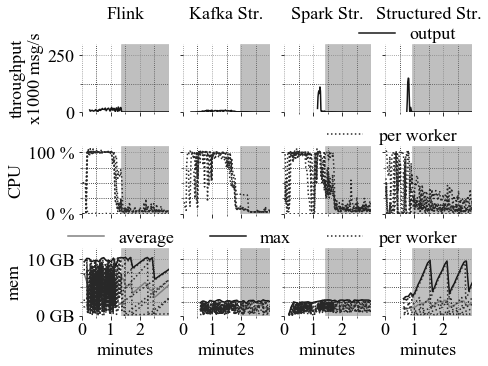

In [198]:
frameworksPrintable = {
    "SPARK": "Spark Str.", 
    "STRUCTUREDSTREAMING":"Structured Str.", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Str."   
}

f, ax = plt.subplots(3, len(frameworks),figsize=(7, 5), sharey='row', sharex='col')
pad = 5

f = open("./figures/single-burst/overall/phase" + str(NOTEBOOK_PHASE) 
                               + "/single-burst-results-phase" + str(NOTEBOOK_PHASE) + ".txt", "w")
for j, framework in enumerate(frameworks):
#     try: 
        throughputData = throughputTimeseriesDataWithStartup[framework] \
            .filter(col("timeSec") <4).toPandas()
        inputThroughputData = inputThroughputTimeseriesDataWithStartup[framework] \
            .filter(col("timeSec") <4).toPandas()
        cpuData = workerCpuTimeseriesDataWithStartup[framework] \
            .filter(col("timeSec") <4).toPandas()
        memoryData = workerMemoryTimeseriesDataWithStartup[framework] \
            .filter(col("timeSec") <4).toPandas()

        generateSingleBurstOverviewChart(j, f, containersPandas=containersPandas, \
                               throughputPandas=throughputData, \
                               inputThroughputPandas=inputThroughputData, \
                               cpuForPlot=cpuData, \
                               memoryForPlot=memoryData)
        ax[0, j].annotate(frameworksPrintable[framework], xy=(0.5, 1.3), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='medium', ha='center', va='baseline', weight="bold")
#     except:
#         print("didnt work ")
f.close()

plt.subplots_adjust(wspace=0.16, hspace=0.50)
save_img_colored_and_grayscale("./figures/single-burst/overall/phase" + str(NOTEBOOK_PHASE) 
                               + "/singleBurstMetricsOverview_phase" + str(NOTEBOOK_PHASE))
plt.show()